In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
citations = pd.read_csv("grants.csv")[["person_id", "gr_num", "RCR"]]

<IPython.core.display.Javascript object>

In [3]:
# Not counting subprojects here, they have 0 funding for the specific PI
data = pd.read_csv("data.csv").query("sp!=1")[
    ["person_id", "fy", "gr_num", "point", "total_awd_amt_adj"]
]

<IPython.core.display.Javascript object>

In [4]:
grant_to_various_rcr = (
    citations.assign(
        RCR_mean=lambda x: x.RCR, RCR_sum=lambda x: x.RCR, RCR_max=lambda x: x.RCR
    )
    .groupby("gr_num")
    .aggregate({"RCR_mean": "mean", "RCR_max": "max", "RCR_sum": "sum"})
    .reset_index()
)

<IPython.core.display.Javascript object>

In [5]:
grant_to_rcr = pd.merge(data, grant_to_various_rcr, how="left").fillna(0)

<IPython.core.display.Javascript object>

In [132]:
# Max impactful work funded by a scientist on one given year
t = grant_to_rcr.groupby(["person_id", "fy"]).aggregate(
    {"RCR_max": "max", "total_awd_amt_adj": "sum"}
)
# median funding
TOL=0.1
N_REPEATS=50000
researchers_funded_around_median = t[
    (t.total_awd_amt_adj < (median_funding *(1+TOL)))
    & (t.total_awd_amt_adj > (median_funding *(1-TOL)))
]
def get_researchers_x_median(x):
    median_funding = t.total_awd_amt_adj.median()
    n_times_m = x * median_funding
    researchers_highly_funded = t[
        (t.total_awd_amt_adj < (n_times_m *(1+TOL)))
        & (t.total_awd_amt_adj > (n_times_m *(1-TOL)))
    ]
    return researchers_highly_funded
def get_diff_for_x_median(x):
#     samples = []
    researchers_highly_funded = get_researchers_x_median(x)
    high_RCR=researchers_highly_funded.sample(N_REPEATS,replace=True).RCR_max.values
    low_RCR=researchers_funded_around_median.sample(N_REPEATS*x,replace=True).RCR_max.values.reshape(
        (N_REPEATS, x)
    ).max(axis=1)
    #samples=high_RCR-low_RCR
#     for i in range(20000):
        # Take one highly funded researcher's max RCR
#         high_RCR = researchers_highly_funded.sample(1).RCR_max.values[0]
#         # Take two low funded researcher's max RCR
#         low_RCR = researchers_funded_around_mean.sample(x).RCR_max.max()
        # Take diff
#         samples.append(high_RCR - low_RCR)
    return high_RCR,low_RCR


<IPython.core.display.Javascript object>

In [155]:
researchers_funded_around_median.RCR_max.max()

299.71

<IPython.core.display.Javascript object>

In [160]:
get_diff_for_x_median(2)[1].max()

299.71

<IPython.core.display.Javascript object>

In [133]:
samples = get_diff_for_x_median(2)
samples = samples[0] - samples[1]
k = pd.Series(samples)
print(k.describe())
# A positive value means an advantage for the highly funded researcher
print(k[k < 0].count() / N_REPEATS)

count    50000.000000
mean         0.354004
std         18.950542
min       -297.740000
25%         -4.900000
50%         -0.150000
75%          5.132500
max        289.080000
dtype: float64
0.5096


<IPython.core.display.Javascript object>

In [138]:
# We are biased in favor of the highly fundd researchers as we are excluding those that led to 0 publications
high_low = (
    pd.DataFrame(get_diff_for_x_median(2))
    .transpose()
    .rename(columns={0: "high", 1: "low"})
)
high_low.query("high!=0").eval("low/high").mean()

0        0.688337
1        0.105687
2        1.574257
3        0.032529
4        4.876855
           ...   
49995    1.013193
49996    0.404607
49997    7.792115
49998    0.147155
49999    0.138191
Length: 48865, dtype: float64

<IPython.core.display.Javascript object>

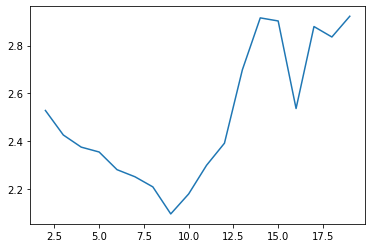

<IPython.core.display.Javascript object>

In [146]:
# The result is robust to doing 2x or 3x etc. Increase after 7.5x median probably because of sampling a very small set that happens
# to be highly cited
bla = []
for i in range(2, 20):
    bla.append(
        pd.DataFrame(get_diff_for_x_median(i))
        .transpose()
        .rename(columns={0: "high", 1: "low"})
        .query("high!=0")
        .eval("low/high")
        .mean()
    )
plt.plot(range(2, 20), bla)

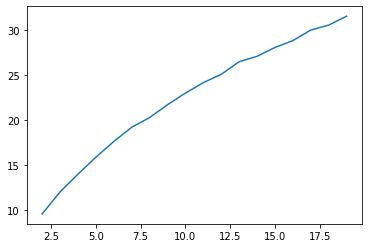

<IPython.core.display.Javascript object>

In [150]:
# Does sampling more in the median case leads to increasing mean? Yeah, more draws = better
bla = []
for i in range(2, 20):
    bla.append(
        pd.DataFrame(get_diff_for_x_median(i))
        .transpose()
        .rename(columns={0: "high", 1: "low"})
        .low.mean()
    )
plt.plot(range(2, 20), bla)

In [162]:
# Max RCR in the median
researchers_funded_around_median.RCR_max.max()

299.71

<IPython.core.display.Javascript object>

(0.0, 350.0)

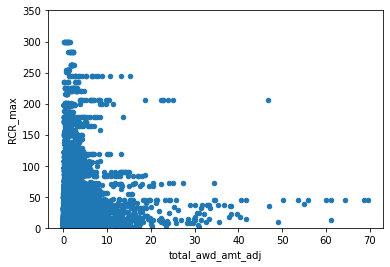

<IPython.core.display.Javascript object>

In [179]:
t.plot.scatter("total_awd_amt_adj", "RCR_max")
# plt.xscale("log")
# plt.yscale("log")
plt.ylim([0, 350])

Text(0, 0.5, 'Median funding for PI-year in that quantile (adj. M$)')

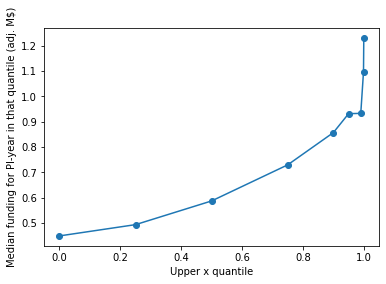

<IPython.core.display.Javascript object>

In [202]:
quants = [0, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999, 0.9999]
res = [t[t.RCR_max > t.RCR_max.quantile(q)].total_awd_amt_adj.median() for q in quants]
plt.plot(quants, res, marker="o")
plt.xlabel("Upper x quantile")
plt.ylabel("Median funding for PI-year in that quantile (adj. M$)")

Text(0, 0.5, 'Number of papers in the top ')

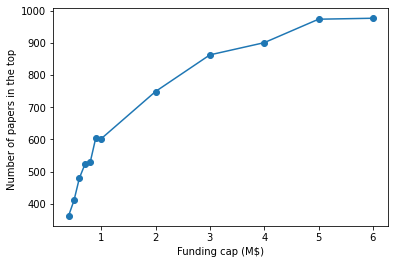

<IPython.core.display.Javascript object>

In [249]:
# Top 1%
top=t.RCR_max.quantile(0.99)
quants = [0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6]
res = [t.query("total_awd_amt_adj<@q").sample(100000, replace=True).query("RCR_max>@top").count().RCR_max for q in quants]
plt.plot(quants, res, marker="o")
plt.xlabel("Funding cap (M$)")
plt.ylabel("Number of papers in the top ")


In [284]:
k = 2
N_SAMPLES = 50000
top = t.RCR_max.quantile(0.99)
res = []
for _ in range(100):
    at_2x = get_researchers_x_median(k).RCR_max.sample(N_SAMPLES, replace=True)
    at_median = researchers_funded_around_median.RCR_max.sample(
        N_SAMPLES * k, replace=True
    )
    res.append(at_2x[at_2x > top].count() / at_median[at_median > top].count())
# print(f"The highly funded group gets {at_2x[at_2x > top].count()}")
# print(f"The low funded group gets {at_median[at_median > top].count()}")
print(sum(res) / len(res))

1.2208161955234904


<IPython.core.display.Javascript object>